## Synopsis
This code fits the scaled global curve of SAXS with the Lorentzian function: 

$$ \large I = \frac{I_{q_0}(T)}{1+(\xi(T) \cdot q)^\eta} $$  

Here, $\xi(T)$ is the characteristic length at temperature $T$, and $I_{q_0}$ corresponds to the SAXS intensity at $q=0$.  

The fitting is done in 3 steps:

1. Normalize the intensity from `SAXS_Global_Scale` using $I_{norm} = I/I_{q_0}$.
2. A linear regression to determine $\eta$ by fitting the overlapped SAXS in `SAXS_Global_Scale`, i.e., fitting $\log(1/I_{norm} -1)$ vs. $\log x$ with a linear function $y= a\cdot x+b$. The slope of the linear function is $\eta$. 
3. (Debug) Using $\eta$ from Step 2 as an initial guess, fit the scaled global SAXS curve with the Lorentzian of $I = I_{q_0}(T)/(1+(\xi(T) \cdot q)^\eta)$ to check the fitting quality

### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D
from saxs_tools import combine_scaled_data, normalize_scaled_curves, lorentzian_fit

### Loading the scaled curve from `SAXS_Global_Scale`

In [2]:

with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)


### Step 1: Normalize Scaled SAXS

In [3]:

# Combine the scaled data
combined_x, combined_y = combine_scaled_data(scaled_curves)

# Debug: Check data ranges
# print(f"Combined X Range: {combined_x.min()} to {combined_x.max()}")
# print(f"Combined Y Range: {combined_y.min()} to {combined_y.max()}")

# Normalize y for better numerical stability
normalized_y = combined_y / np.max(combined_y)

# Add a small epsilon to avoid infinities in the transformation
epsilon = 1e-10
normalized_y = np.clip(normalized_y, epsilon, 1 - epsilon)


### Step 2: Linear Regression Fit

Linear Fit Parameters: slope (b) = 1.7633, log(c) = 7.2259, c = 1.3746e+03


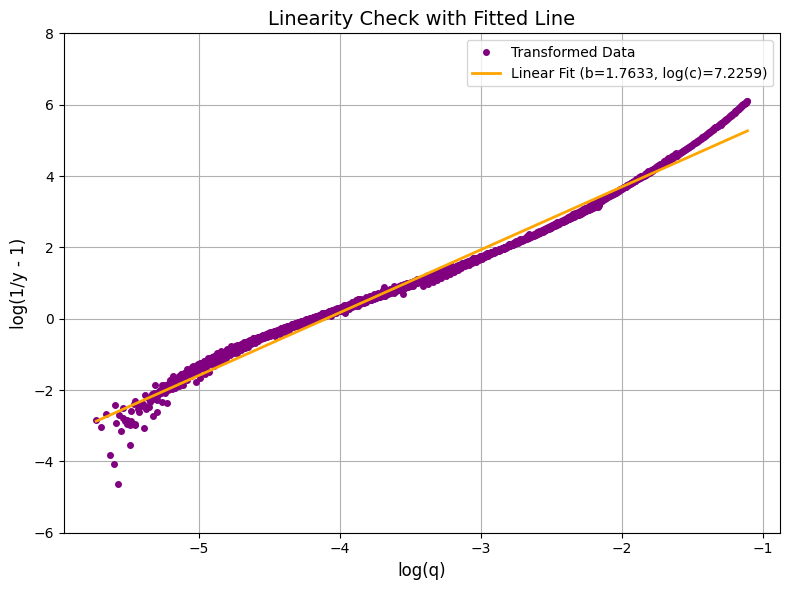

In [4]:

# Calculate log(1/y - 1) and log(x)
transformed_y = np.log(1 / normalized_y - 1)
log_x = np.log(combined_x)

# Fit a linear model to log(1/y - 1) vs log(x)
def linear_model(x, m, c):
    return m * x + c

popt, pcov = curve_fit(linear_model, log_x, transformed_y)
b_fixed, log_c_fixed = popt  # Slope and intercept
c_fixed = np.exp(log_c_fixed)  # Convert log(c) to c
print(f"Linear Fit Parameters: slope (b) = {b_fixed:.4f}, log(c) = {log_c_fixed:.4f}, c = {c_fixed:.4e}")

# Generate the fitted line
fitted_line = linear_model(log_x, b_fixed, log_c_fixed)

# Plot the linearity check with fitted line
plt.figure(figsize=(8, 6))
plt.plot(log_x, transformed_y, 'o', label='Transformed Data', color='purple', markersize=4)
plt.plot(log_x, fitted_line, label=f'Linear Fit (b={b_fixed:.4f}, log(c)={log_c_fixed:.4f})', color='orange', linewidth=2)
plt.ylim(-6, 8) 
plt.xlabel('log(q)', fontsize=12)
plt.ylabel('log(1/y - 1)', fontsize=12)
plt.title('Linearity Check with Fitted Line', fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()


### Step 3: Fit the scaled global curve to check the fitting quality of the Lorentzian in the original loglog SAXS plot.

Note that, although the y axis is normalized and the x axis is multiplied by the fitting parameter, but since the x axis is the scaled version from `iterative_scaling`, it's still not the true $q \cdot \xi$ and can only be used as a check for the quality of the global Lorentzian fit.


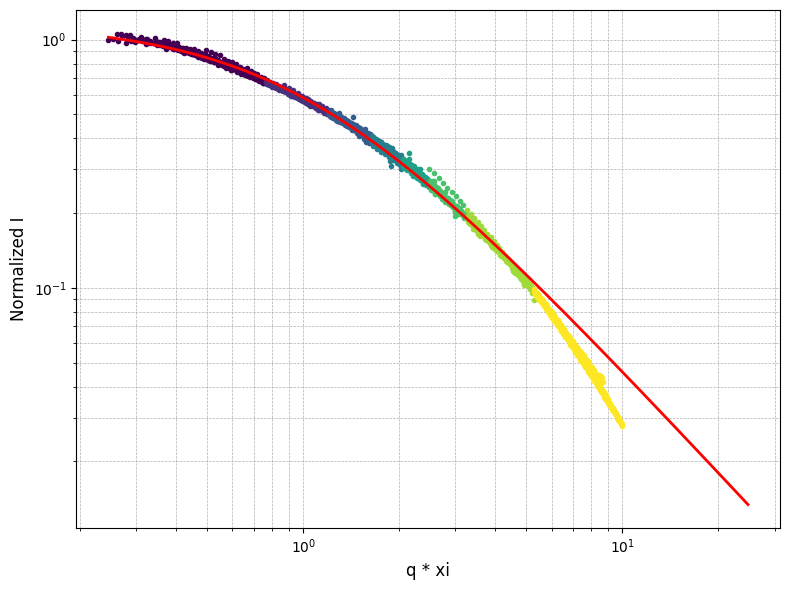

In [5]:

normalized_q, normalized_i = normalize_scaled_curves(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b as a free parameter
popt, _ = curve_fit(lorentzian_fit, filtered_x, filtered_y, p0=[np.max(filtered_y), 1, 1.7], 
                    bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# Extract parameters
Iq0_fit, x_fit, b_fit = popt

# Generate fitted curve
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit(extended_x, Iq0_fit, x_fit, b_fit)

# Apply scaling to x-axis using x_fit
scaled_x = filtered_x * x_fit
extended_scaled_x = extended_x * x_fit
# Plot the final normalized and fitted curve
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate 8 distinct colors

for i in range(8):
    start_idx = i * 259
    end_idx = (i + 1) * 259
    plt.loglog(scaled_x[start_idx:end_idx], filtered_y[start_idx:end_idx], 'o', color=colors[i], markersize=3)
plt.loglog(extended_scaled_x, fitted_y, color='red', linewidth=2)
plt.xlabel('q * xi', fontsize=12)
plt.ylabel('Normalized I', fontsize=12)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./Intermediate_Figures/normalized_fitted_curve.pdf')
plt.show()
